In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import config as c

from datetime import datetime

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns
# sns.set(context='paper', style='white', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

from math import sqrt

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Import tools needed for visualization of tree
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
# Dataframe Pre-Processing
def data_pre_processing(df):
    df['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['Datetime']]

    # Making sure there are no duplicated data
    # If there are some duplicates we average the data during those duplicated days
    df = df.groupby('Datetime', as_index=False)['kwh'].mean()

    # Sorting the values
    df.sort_values('Datetime', inplace=True)

    #Setting index date
    df.set_index(df['Datetime'], inplace=True)
    #Dropping column Datetime
    df.drop('Datetime', axis = 1, inplace=True)

    # Remove outlier data
    df.drop(df[df.kwh < 0.001].index, inplace=True)
    df.drop(df[df.kwh > 1.0].index, inplace=True)

    return df

In [3]:
# LOAD DATASET
df = pd.read_csv(f"{c.loc_dat}/Datetime_kwh_hr_2001_3103_org.csv")


In [4]:
# Daily Dataframe Trend Plot
df = data_pre_processing(df)
df = df.resample('D').sum()
# Removing data values from dataframe
df.drop(df[df.kwh < 2].index, inplace=True)
df.drop(df[df.kwh > 7].index, inplace=True)
#Reset Index
df1 = df.reset_index()
#Get dataframe shape
df1.shape

(71, 2)

In [5]:
# Use numpy to convert to arrays
# Make a copy of features
features = df1.copy()

# Labels are the values we want to predict
labels = np.array(features['kwh'])

# Remove the labels from the features
features= features.drop('kwh', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [6]:
# Using Skicit-learn to split data into training and testing sets


# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.10, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (63, 1)
Training Labels Shape: (63,)
Testing Features Shape: (8, 1)
Testing Labels Shape: (8,)


In [7]:
# Instantiate model 1
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

In [8]:
# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'kwh')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%')

Mean Absolute Error: 0.62 kwh
Accuracy: 83.99 %


In [9]:
# Get predictions, test labels and errors array
# predictions
# test_labels
# errors

In [10]:
#Accuracy metrics for the forecast: forecast bias, mean absolute error, mean squared error, and root mean square error
expected = test_labels
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
mae = mean_absolute_error(expected, predictions)
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('Forecast Errors: %s' % forecast_errors)
print('Bias: %f' % bias)
print('MAE: %f' % mae)
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)

Forecast Errors: [-0.15625649999996716, -0.5996307000000218, -0.47698740000004936, 0.7114474999999638, -0.923346700000006, -1.1066471999999146, -0.7044206000000184, 0.2768409999999717]
Bias: -0.372375
MAE: 0.619447
MSE: 0.470967
RMSE: 0.686270


In [11]:
#Resample by day
dfD = df.resample('D').sum()
dfD.reset_index(inplace=True)
#Adding new features year, month and day
dfD['year'] = pd.to_datetime(dfD['Datetime']).dt.year
dfD['month'] = pd.to_datetime(dfD['Datetime']).dt.month
dfD['day'] = pd.to_datetime(dfD['Datetime']).dt.day
dfD.drop('Datetime',axis = 1, inplace = True)
#Changing column positions
dfD = dfD[['year','month','day','kwh']]
#dfD

In [12]:
#To make a copy of dataframe to work with
features = dfD.copy()

# Get years, months, and days
years = dfD['year']
months = dfD['month']
days = dfD['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

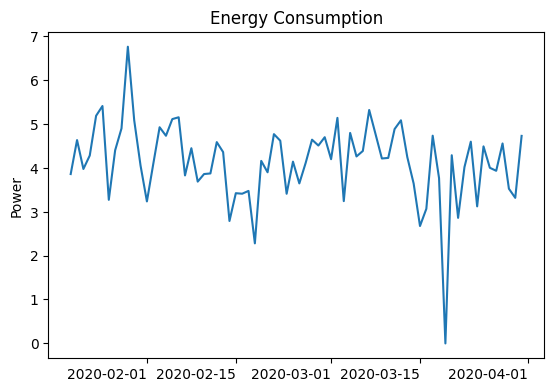

In [13]:
# Set up the plotting layout
fig, ax = plt.subplots()
fig.autofmt_xdate(rotation = 0)

# Actual max temperature measurement
ax.plot(dates, dfD['kwh'])
ax.set_xlabel(''); ax.set_ylabel('Power'); ax.set_title('Energy Consumption')

plt.show()

In [14]:
print('The shape of our features is:', features.shape)

The shape of our features is: (72, 4)


In [15]:
# Labels are the values we want to predict
labels = np.array(features['kwh'])

# Remove the labels from the features
features= features.drop('kwh', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [16]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (54, 3)
Training Labels Shape: (54,)
Testing Features Shape: (18, 3)
Testing Labels Shape: (18,)


In [17]:
# Instantiate model 1
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

In [18]:
# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'kwh')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%')

Mean Absolute Error: 0.69 kwh
Accuracy: 84.87 %


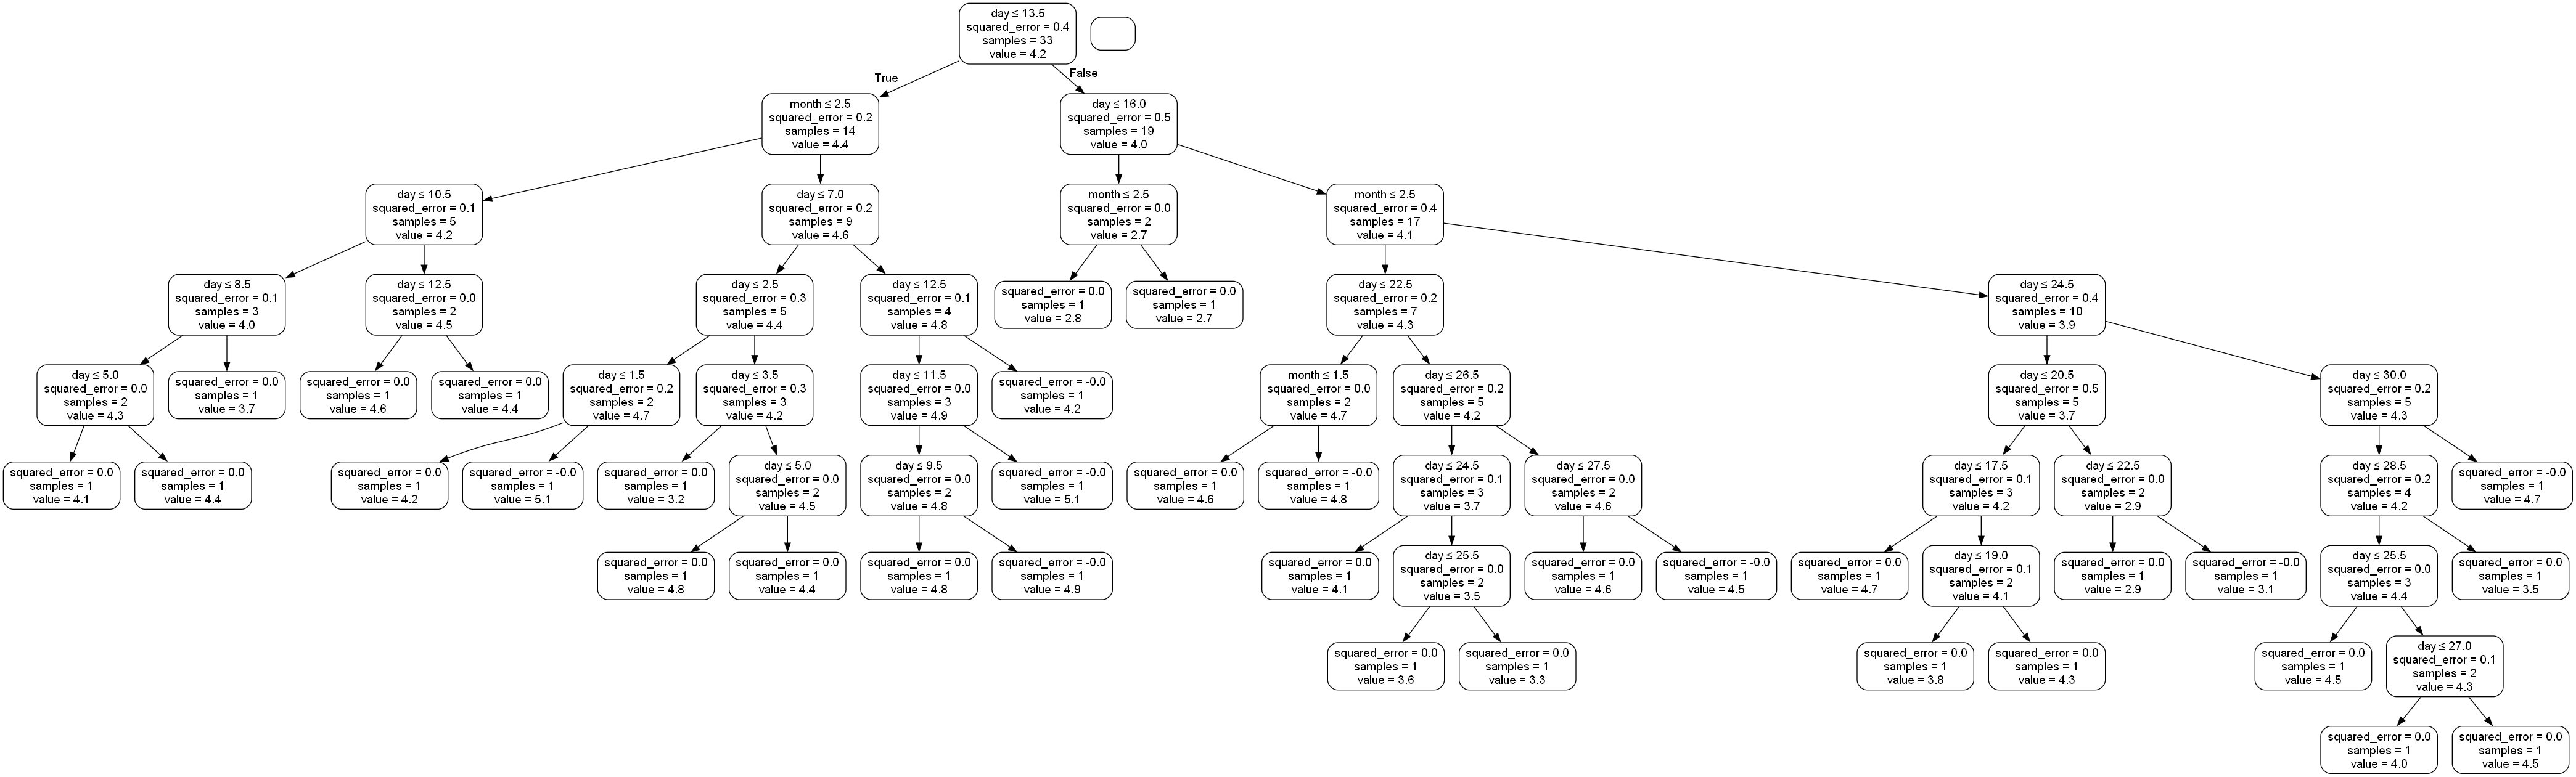

In [19]:
# Display decision trees
# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = f"{c.loc_out}/tree.dot", feature_names = feature_list, rounded = True, precision = 1, special_characters=True, leaves_parallel=False)

# Use dot file to create a graph
graph = pydotplus.graphviz.graph_from_dot_file(f"{c.loc_out}/tree.dot")

# Write graph to a png file
graph.write_png(f"{c.loc_fig}/tree_gv.png")

# Show the image file
Image(filename=f"{c.loc_fig}/tree_gv.png")

In [20]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 8


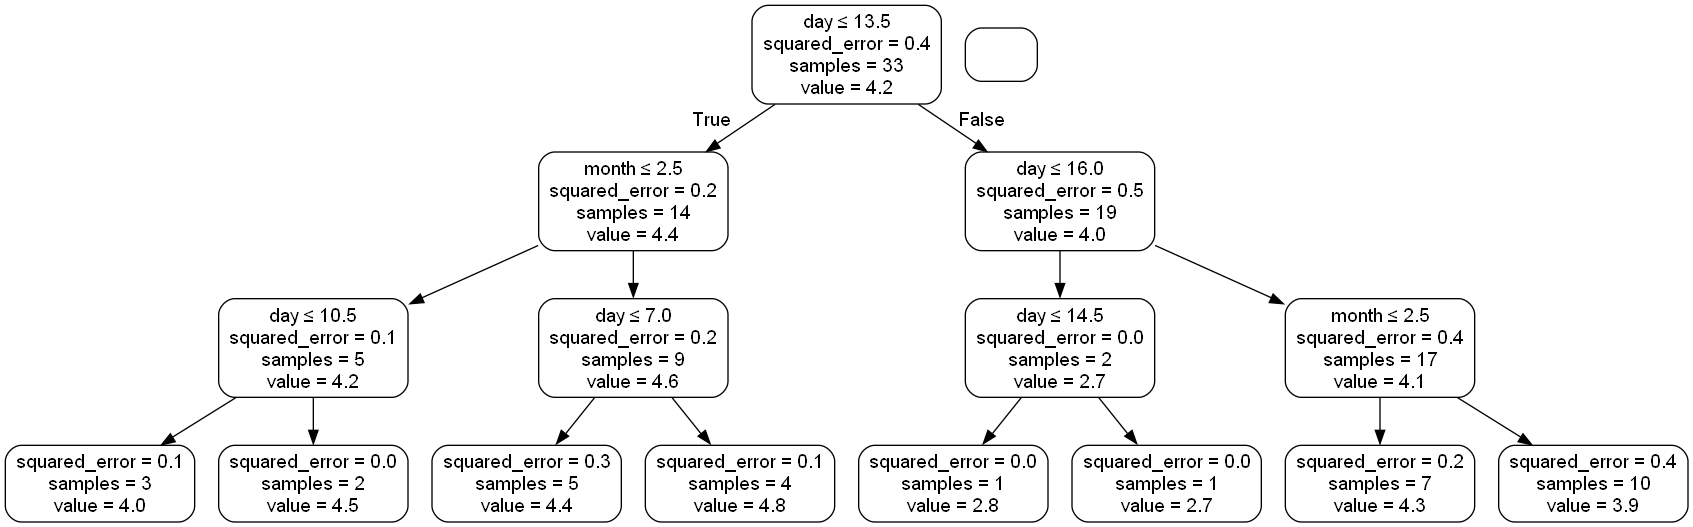

In [21]:
# Limit depth of tree to 2 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3, random_state=42)
rf_small.fit(train_features, train_labels)

# Extract the small tree
tree_small = rf_small.estimators_[5]

# Export the small tree
export_graphviz(tree_small, out_file = f"{c.loc_out}/small_tree.dot", feature_names = feature_list, rounded = True, precision = 1, special_characters=True, leaves_parallel=False)

# Use dot file to create a graph
small_graph = pydotplus.graphviz.graph_from_dot_file(f"{c.loc_out}/small_tree.dot")

# Write graph to a png file
small_graph.write_png(f"{c.loc_fig}/small_tree_gv.png")

# Show the image file
Image(filename=f"{c.loc_fig}/small_tree_gv.png")

In [22]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: day                  Importance: 0.83
Variable: month                Importance: 0.17
Variable: year                 Importance: 0.0


In [23]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('day'), feature_list.index('month')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'kwh')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%')

Mean Absolute Error: 0.69 kwh
Accuracy: 84.86 %


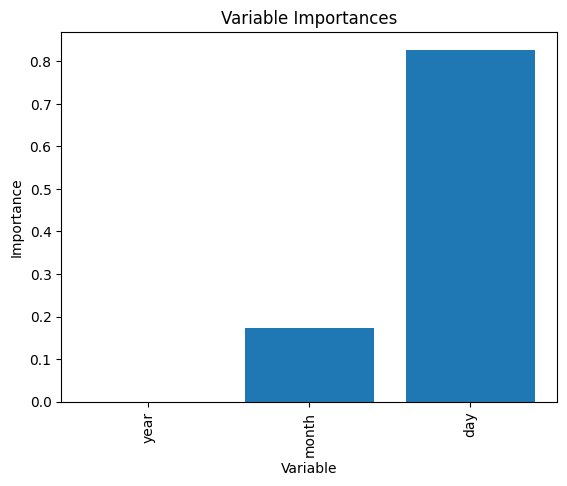

In [24]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [25]:
# Dates of training values
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

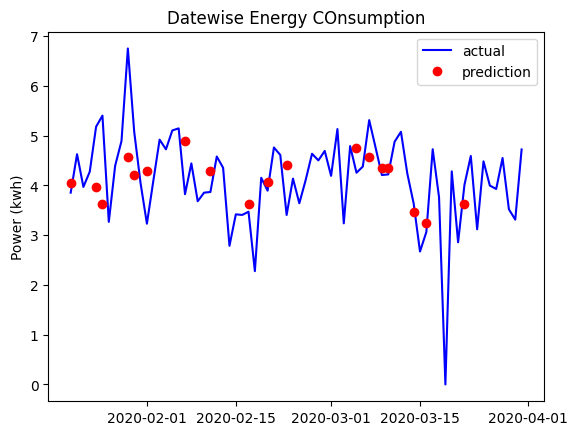

In [26]:
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
# plt.xticks(rotation = '0'); 
plt.legend()

# Graph labels
plt.xlabel(''); plt.ylabel('Power (kwh)'); plt.title('Datewise Energy COnsumption');